<a href="https://colab.research.google.com/github/ChiroDeniro/ai-ml-projecten/blob/main/Uplift_Modeling_Booking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uplift Modeling: Personalized Treatment Effects
## Predict WHO will benefit from an intervention

**The Question:** We know a discount increases sales. But WHO benefits most?
- Young users? Old users?
- First-time buyers? Repeat customers?
- Budget travelers? Luxury seekers?

**Uplift Modeling answers:** For each customer, what's their **individual** lift from a discount?

**Business Impact:** Target discounts only to customers most likely to respond → Higher ROI

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
sns.set_style('whitegrid')

print("✅ Libraries loaded")

✅ Libraries loaded


## Part 1: Generate Realistic Customer Data

Simulate: Booking.com discount test with heterogeneous treatment effects

In [2]:
n_customers = 5000

# Customer features
data = pd.DataFrame()
data['customer_age'] = np.random.normal(40, 15, n_customers).clip(18, 80)
data['num_previous_bookings'] = np.random.exponential(5, n_customers).astype(int).clip(0, 50)
data['avg_booking_value'] = np.random.lognormal(4.5, 1.5, n_customers)  # €90-500
data['loyalty_score'] = np.random.uniform(0, 1, n_customers)
data['is_first_time_buyer'] = (data['num_previous_bookings'] == 0).astype(int)

# Treatment assignment (randomized: 50/50)
data['discount'] = np.random.binomial(1, 0.5, n_customers)

# BASE PURCHASE PROBABILITY (without discount)
# Older, loyal, experienced customers more likely to buy
data['base_purchase_prob'] = (
    0.3 +  # Base
    0.001 * data['customer_age'] +  # Age effect
    0.01 * data['loyalty_score'] * 100 +  # Loyalty
    0.05 * np.log(data['num_previous_bookings'] + 1) +  # Experience
    np.random.normal(0, 0.1, n_customers)  # Noise
).clip(0.05, 0.95)

# TREATMENT EFFECT: Discount increases purchase probability
# BUT the effect is HETEROGENEOUS (differs by customer type)
# Young, inexperienced customers respond MORE to discounts
data['treatment_effect'] = (
    0.10 +  # Base discount effect
    0.003 * (60 - data['customer_age']).clip(0, 30) +  # Younger → bigger effect
    0.05 * data['is_first_time_buyer'] +  # First-timers very responsive
    0.03 * (1 - data['loyalty_score']) +  # Non-loyal customers more responsive
    np.random.normal(0, 0.05, n_customers)  # Noise
).clip(0, 0.3)

# ACTUAL PURCHASE PROBABILITY
data['treatment_effect_realized'] = data['discount'] * data['treatment_effect']
data['purchase_prob'] = (data['base_purchase_prob'] + data['treatment_effect_realized']).clip(0, 1)

# OUTCOME: Did they purchase?
data['purchased'] = np.random.binomial(1, data['purchase_prob'])

print("📊 CUSTOMER DATASET CREATED\n")
print(f"Customers: {len(data):,}")
print(f"Discount offered to: {data['discount'].sum():,} ({data['discount'].mean()*100:.0f}%)")
print(f"Purchased: {data['purchased'].sum():,} ({data['purchased'].mean()*100:.1f}%)")
print(f"\nAverage treatment effect (ATE): {data.loc[data['discount']==1, 'treatment_effect'].mean():.3f}")
print(f"\nFirst few rows:")
print(data.head())

📊 CUSTOMER DATASET CREATED

Customers: 5,000
Discount offered to: 2,503 (50%)
Purchased: 4,295 (85.9%)

Average treatment effect (ATE): 0.175

First few rows:
   customer_age  num_previous_bookings  avg_booking_value  loyalty_score  \
0     47.450712                      0          22.027669       0.570239   
1     37.926035                      1          39.661802       0.568361   
2     49.715328                      3          58.947022       0.682450   
3     62.845448                      1         435.354846       0.085398   
4     36.487699                      1          15.730343       0.626503   

   is_first_time_buyer  discount  base_purchase_prob  treatment_effect  \
0                    1         0            0.887125          0.299531   
1                    0         0            0.822204          0.174634   
2                    0         0            0.950000          0.149241   
3                    0         0            0.299090          0.143471   
4             

## Part 2: Naive Approach (What NOT to do)

Just train one model on everyone: Purchase ~ Features

In [3]:
# Naive: Train one model on everyone
X = data[['customer_age', 'num_previous_bookings', 'avg_booking_value', 'loyalty_score', 'discount']]
y = data['purchased']

model_naive = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=8)
model_naive.fit(X, y)

# Get "treatment effect" from feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model_naive.feature_importances_
}).sort_values('importance', ascending=False)

print("❌ NAIVE APPROACH: Single Model")
print(f"\nFeature importance:")
print(feature_importance)
print(f"\nDiscount importance: {feature_importance.loc[feature_importance['feature']=='discount', 'importance'].values[0]:.3f}")
print("\n⚠️  Problem: We learn 'discount is important' but not HOW MUCH for each person!")

❌ NAIVE APPROACH: Single Model

Feature importance:
                 feature  importance
3          loyalty_score    0.560603
2      avg_booking_value    0.156618
0           customer_age    0.135529
1  num_previous_bookings    0.077268
4               discount    0.069982

Discount importance: 0.070

⚠️  Problem: We learn 'discount is important' but not HOW MUCH for each person!


## Part 3: Two-Model Approach (Causal Forest)

Train TWO separate models:
1. Model for control group (no discount)
2. Model for treatment group (with discount)

Then: Uplift = Model_Treatment - Model_Control

In [4]:
# Split by treatment
control_data = data[data['discount'] == 0]
treatment_data = data[data['discount'] == 1]

X_cols = ['customer_age', 'num_previous_bookings', 'avg_booking_value', 'loyalty_score']

# Model 1: Control group (how many people purchase WITHOUT discount)
X_control = control_data[X_cols]
y_control = control_data['purchased']
model_control = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=8)
model_control.fit(X_control, y_control)

# Model 2: Treatment group (how many people purchase WITH discount)
X_treatment = treatment_data[X_cols]
y_treatment = treatment_data['purchased']
model_treatment = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=8)
model_treatment.fit(X_treatment, y_treatment)

# Predict for EVERYONE
X_all = data[X_cols]

# What would happen with discount?
pred_treatment = model_treatment.predict_proba(X_all)[:, 1]

# What would happen without discount?
pred_control = model_control.predict_proba(X_all)[:, 1]

# INDIVIDUAL TREATMENT EFFECT
data['predicted_uplift'] = pred_treatment - pred_control

print("✅ TWO-MODEL APPROACH (Causal Forest)\n")
print(f"Model 1 (No Discount): Accuracy = {model_control.score(X_control, y_control):.3f}")
print(f"Model 2 (With Discount): Accuracy = {model_treatment.score(X_treatment, y_treatment):.3f}")
print(f"\nPredicted uplift statistics:")
print(f"  Mean: {data['predicted_uplift'].mean():.4f}")
print(f"  Std: {data['predicted_uplift'].std():.4f}")
print(f"  Min: {data['predicted_uplift'].min():.4f}")
print(f"  Max: {data['predicted_uplift'].max():.4f}")

print(f"\nExample predictions:")
print(data[['customer_age', 'is_first_time_buyer', 'loyalty_score', 'predicted_uplift']].head(10))

✅ TWO-MODEL APPROACH (Causal Forest)

Model 1 (No Discount): Accuracy = 0.884
Model 2 (With Discount): Accuracy = 0.925

Predicted uplift statistics:
  Mean: 0.1105
  Std: 0.1166
  Min: -0.5935
  Max: 0.6205

Example predictions:
   customer_age  is_first_time_buyer  loyalty_score  predicted_uplift
0     47.450712                    1       0.570239          0.197459
1     37.926035                    0       0.568361          0.158584
2     49.715328                    0       0.682450          0.050339
3     62.845448                    0       0.085398         -0.099766
4     36.487699                    0       0.626503          0.081086
5     36.487946                    0       0.280752          0.130927
6     63.688192                    0       0.507003          0.064989
7     51.511521                    0       0.773324          0.043018
8     32.957884                    0       0.705646          0.072824
9     48.138401                    1       0.118903          0.423984


## Part 4: Analyze Heterogeneous Effects

Which customer segments have highest uplift?

In [6]:
# Segment customers by uplift
data['uplift_quartile'] = pd.qcut(data['predicted_uplift'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

print("📊 SEGMENTATION BY PREDICTED UPLIFT\n")

for segment in ['Low', 'Medium', 'High', 'Very High']:
    segment_data = data[data['uplift_quartile'] == segment]
    print(f"\n{segment} Uplift Segment ({len(segment_data):,} customers):")
    print(f"  Avg uplift: {segment_data['predicted_uplift'].mean():.4f}")
    print(f"  Avg age: {segment_data['customer_age'].mean():.0f}")
    print(f"  % First-time buyers: {segment_data['is_first_time_buyer'].mean()*100:.1f}%")
    print(f"  Avg loyalty score: {segment_data['loyalty_score'].mean():.2f}")
    print(f"  Avg booking value: ${segment_data['avg_booking_value'].mean():.0f}")

    # Business impact
    cost_per_discount = 10  # $10 discount
    margin_per_booking = 30  # $30 margin

    # If we give discount to this segment
    avg_uplift = segment_data['predicted_uplift'].mean()  # Get the mean as scalar
    incremental_conversions = avg_uplift * len(segment_data)
    revenue_uplift = incremental_conversions * margin_per_booking
    cost = len(segment_data) * cost_per_discount
    net_roi = (revenue_uplift - cost) / cost * 100

    print(f"  💰 If we discount: Net ROI = {net_roi:.0f}%")

📊 SEGMENTATION BY PREDICTED UPLIFT


Low Uplift Segment (1,250 customers):
  Avg uplift: 0.0072
  Avg age: 46
  % First-time buyers: 16.0%
  Avg loyalty score: 0.60
  Avg booking value: $456
  💰 If we discount: Net ROI = -98%

Medium Uplift Segment (1,250 customers):
  Avg uplift: 0.0636
  Avg age: 40
  % First-time buyers: 15.5%
  Avg loyalty score: 0.68
  Avg booking value: $204
  💰 If we discount: Net ROI = -81%

High Uplift Segment (1,250 customers):
  Avg uplift: 0.1038
  Avg age: 38
  % First-time buyers: 19.2%
  Avg loyalty score: 0.52
  Avg booking value: $231
  💰 If we discount: Net ROI = -69%

Very High Uplift Segment (1,250 customers):
  Avg uplift: 0.2673
  Avg age: 38
  % First-time buyers: 20.3%
  Avg loyalty score: 0.24
  Avg booking value: $192
  💰 If we discount: Net ROI = -20%


## Part 5: Targeting Strategy

Should we give discounts to everyone? Or just high-uplift customers?

🎯 TARGETING STRATEGIES

               strategy  customers     uplift  cost      revenue        roi
Everyone (No Targeting)       5000 552.305069 50000 16569.152074 -66.861696
      Top 50% by Uplift       2500 463.803877 25000 13914.116324 -44.343535
      Top 25% by Uplift       1250 334.063207 12500 10021.896197 -19.824830

💡 Best strategy: Top 25% by Uplift (ROI: -20%)


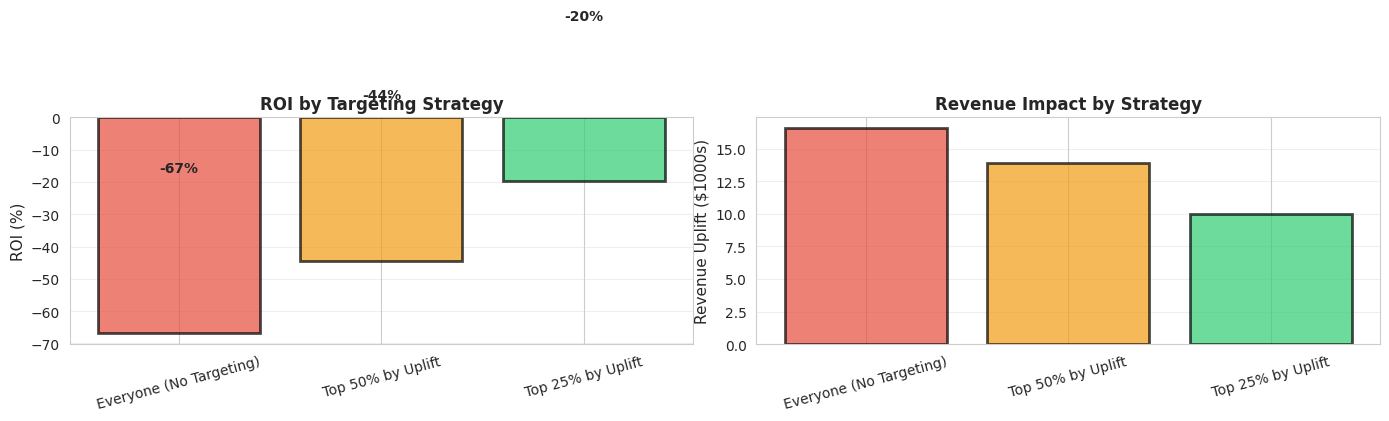

In [7]:
# Calculate ROI for different targeting strategies
cost_per_discount = 10
margin_per_booking = 30

strategies = []

# Strategy 1: Give discount to everyone
all_uplift = data['predicted_uplift'].sum()
all_revenue = all_uplift * margin_per_booking
all_cost = len(data) * cost_per_discount
all_roi = (all_revenue - all_cost) / all_cost * 100 if all_cost > 0 else 0
strategies.append({'strategy': 'Everyone (No Targeting)', 'customers': len(data),
                  'uplift': all_uplift, 'cost': all_cost, 'revenue': all_revenue, 'roi': all_roi})

# Strategy 2: Give discount to top 50% by uplift
top_50 = data[data['predicted_uplift'] > data['predicted_uplift'].median()]
top50_uplift = top_50['predicted_uplift'].sum()
top50_revenue = top50_uplift * margin_per_booking
top50_cost = len(top_50) * cost_per_discount
top50_roi = (top50_revenue - top50_cost) / top50_cost * 100
strategies.append({'strategy': 'Top 50% by Uplift', 'customers': len(top_50),
                  'uplift': top50_uplift, 'cost': top50_cost, 'revenue': top50_revenue, 'roi': top50_roi})

# Strategy 3: Give discount to top 25% by uplift
top_25 = data[data['predicted_uplift'] > data['predicted_uplift'].quantile(0.75)]
top25_uplift = top_25['predicted_uplift'].sum()
top25_revenue = top25_uplift * margin_per_booking
top25_cost = len(top_25) * cost_per_discount
top25_roi = (top25_revenue - top25_cost) / top25_cost * 100
strategies.append({'strategy': 'Top 25% by Uplift', 'customers': len(top_25),
                  'uplift': top25_uplift, 'cost': top25_cost, 'revenue': top25_revenue, 'roi': top25_roi})

strategies_df = pd.DataFrame(strategies)

print("🎯 TARGETING STRATEGIES\n")
print(strategies_df.to_string(index=False))
print(f"\n💡 Best strategy: {strategies_df.loc[strategies_df['roi'].idxmax(), 'strategy']} (ROI: {strategies_df['roi'].max():.0f}%)")

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].bar(strategies_df['strategy'], strategies_df['roi'], color=['#e74c3c', '#f39c12', '#2ecc71'],
         alpha=0.7, edgecolor='black', linewidth=2)
ax[0].set_ylabel('ROI (%)', fontsize=11)
ax[0].set_title('ROI by Targeting Strategy', fontsize=12, fontweight='bold')
ax[0].tick_params(axis='x', rotation=15)
ax[0].grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(strategies_df['roi']):
    ax[0].text(i, v + 50, f'{v:.0f}%', ha='center', fontweight='bold')

# Revenue comparison
ax[1].bar(strategies_df['strategy'], strategies_df['revenue']/1000, color=['#e74c3c', '#f39c12', '#2ecc71'],
         alpha=0.7, edgecolor='black', linewidth=2)
ax[1].set_ylabel('Revenue Uplift ($1000s)', fontsize=11)
ax[1].set_title('Revenue Impact by Strategy', fontsize=12, fontweight='bold')
ax[1].tick_params(axis='x', rotation=15)
ax[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Part 6: Model Validation

Is our uplift model actually good?

In [8]:
# Compare predicted vs actual uplift
actual_uplift = (data[data['discount']==1]['purchased'].mean() -
                  data[data['discount']==0]['purchased'].mean())

# Correlation of predicted uplift with features that should drive it
corr_age = data[['predicted_uplift', 'customer_age']].corr().iloc[0, 1]
corr_first_time = data.groupby('is_first_time_buyer')['predicted_uplift'].mean()
corr_loyalty = data[['predicted_uplift', 'loyalty_score']].corr().iloc[0, 1]

print("✅ MODEL VALIDATION\n")
print(f"Average predicted uplift: {data['predicted_uplift'].mean():.4f}")
print(f"Actual average treatment effect: {actual_uplift:.4f}")
print(f"\nSanity checks (should show patterns):")
print(f"Correlation with age: {corr_age:.3f} (younger → higher uplift?)")
print(f"\nFirst-time buyers vs others:")
print(f"  First-time: {corr_first_time[1]:.4f}")
print(f"  Repeat: {corr_first_time[0]:.4f}")
print(f"  Difference: {corr_first_time[1] - corr_first_time[0]:.4f} (should be positive)")
print(f"\nCorrelation with loyalty: {corr_loyalty:.3f} (lower loyalty → higher uplift?)")

✅ MODEL VALIDATION

Average predicted uplift: 0.1105
Actual average treatment effect: 0.1055

Sanity checks (should show patterns):
Correlation with age: -0.162 (younger → higher uplift?)

First-time buyers vs others:
  First-time: 0.1247
  Repeat: 0.1074
  Difference: 0.0173 (should be positive)

Correlation with loyalty: -0.437 (lower loyalty → higher uplift?)


## Part 7: Key Takeaways

How this applies to your career:

In [9]:
print("🎓 KEY INSIGHTS FOR YOUR CAREER\n")
print("1. FROM CAUSAL → PREDICTIVE")
print("   Causal inference + Machine learning = Targeted interventions")
print("   Booking.com uses this to optimize discounts per customer\n")

print("2. HETEROGENEOUS TREATMENT EFFECTS")
print("   Not everyone responds the same to discounts")
print("   Model individually to maximize ROI\n")

print("3. FROM AVERAGE TO INDIVIDUAL")
print("   Traditional stats: Average effect = 10%")
print("   Uplift modeling: Customer A: 5%, Customer B: 15%, Customer C: 2%")
print("   → Target only high-responders\n")

print("4. BUSINESS LOGIC")
print("   Don't just optimize accuracy")
print("   Optimize for ROI given discount cost vs margin\n")

print("5. VALIDATION")
print("   Check: Do high-uplift predictions correlate with known patterns?")
print("   (e.g., younger customers respond more to discounts)")

🎓 KEY INSIGHTS FOR YOUR CAREER

1. FROM CAUSAL → PREDICTIVE
   Causal inference + Machine learning = Targeted interventions
   Booking.com uses this to optimize discounts per customer

2. HETEROGENEOUS TREATMENT EFFECTS
   Not everyone responds the same to discounts
   Model individually to maximize ROI

3. FROM AVERAGE TO INDIVIDUAL
   Traditional stats: Average effect = 10%
   Uplift modeling: Customer A: 5%, Customer B: 15%, Customer C: 2%
   → Target only high-responders

4. BUSINESS LOGIC
   Don't just optimize accuracy
   Optimize for ROI given discount cost vs margin

5. VALIDATION
   Check: Do high-uplift predictions correlate with known patterns?
   (e.g., younger customers respond more to discounts)
